In [1]:
# The import cell, Need to run this first for remaining ones to work
import os
import numpy as np
import pandas as pd
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import threading
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from skimage.feature import hog
from sklearn.decomposition import PCA

# Image Augmentation:  
1. Increase training data set  
2. Implement the following probably:  
    Shifting  
    Shearing  
    Cropping  
    Rotating  
    Zooming  
    Flipping  
    Changing Brightness Level  

In [11]:

def ImageAugmentation(path):
    image = load_img(path)
    file_name = path.split('/')[-1].split('.')[0]
    data = img_to_array(image)

    datagen = ImageDataGenerator(
            width_shift_range=25.0,
            height_shift_range=25.0,
            rotation_range = 20,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = False,
            brightness_range = (0.5, 1.5))

    data = data.reshape((1, ) + data.shape)

    path_to_save = "generated_images/" + path.split('/')[-2]

    i = 0
    for batch in datagen.flow(data, batch_size = 1, save_to_dir =path_to_save, save_prefix =file_name, save_format ='jpg'):
        i += 1
        if i > 3:
            break

def start_creating(c):
    global threads
    directory_path = train_path + c
    with os.scandir(directory_path) as entries:
        for entry in entries:
            print("Generating for image " + entry.name)
            path = directory_path + '/' + entry.name
            ImageAugmentation(path)
            
    print(c + 'is done')

train_path = 'Images/imgs/train/'
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
threads = []

for c in classes:
    thread = threading.Thread(target=start_creating, args=(c,), daemon=True)
    threads.append(thread)

for i in range(10):
    threads[i].start()
for i in range(10):
    threads[i].join()


Generating for image img_89511.jpg
Generating for image img_95598.jpg
Generating for image img_95526.jpg
Generating for image img_97577.jpg
Generating for image img_89526.jpg
Generating for image img_9563.jpg
Generating for image img_95573.jpg
Generating for image img_97598.jpg
Generating for image img_8954.jpg
Generating for image img_95639.jpg
Generating for image img_97645.jpg
Generating for image img_95594.jpg
Generating for image img_95711.jpg
Generating for image img_89574.jpg
Generating for image img_97673.jpg
Generating for image img_95599.jpg
Generating for image img_95740.jpg
Generating for image img_89586.jpg
Generating for image img_97717.jpg
Generating for image img_9572.jpg
Generating for image img_95859.jpg
Generating for image img_89613.jpg
Generating for image img_97787.jpg
Generating for image img_95737.jpg
Generating for image img_95892.jpg
Generating for image img_89621.jpg
Generating for image img_97808.jpg
Generating for image img_95744.jpg
Generating for image im

Here, I plan to implement image preprocessing. (incomplete)  
Steps I plan to do:  
1. Read Image  
2. Resize image/matrix  
3. Remove noise if possible  
4. Any optimizations such as reducing size( will have to see what is possible)  

For this now I try to preprocess a single image and see what steps are involved  

In [29]:
np.set_printoptions(threshold=np.inf)

def preprocessing(image_path):
  global final_dataframe
  try:
    img = cv2.imread(image_path)
  except IOError:
    print("image could not be found")

  height, width, columns = img.shape

  height = 64
  width = 64
  img = cv2.resize(img, (height, width), interpolation=cv2.INTER_LINEAR)

  img = img.flatten()
  image_person, image_class = find_person(image_path)
  
  final_dataframe = final_dataframe.append({'Image_name': image_path.split("/")[-1], 
                                            "Person": image_person, 
                                            "Vector": img, 
                                            "Class": image_class}
                                            ,ignore_index=True)

def find_person(image_path):
  global driver_imgs_list
  image_name = image_path.split("/")[-1]
  if(image_name.count('_') > 1):
    temp = image_name.split('_')
    image_name = temp[0] + '_' + temp[1] + '.jpg'
  person_details = driver_imgs_list.loc[driver_imgs_list["img"] == image_name]
  image_person = person_details["subject"].values[0]
  image_class = person_details["classname"].values[0][1:]
  return (image_person, image_class)

def start_processing(c, directory_path):
  global threads
  final_path = directory_path + c
  with os.scandir(final_path) as entries:
      for entry in entries:
          path = final_path + '/' + entry.name
          preprocessing(path)
          
  print(c + 'is done')

driver_imgs_list = pd.read_csv('Images/driver_imgs_list.csv')
final_dataframe = pd.DataFrame(columns=['Image_name', 'Person', 'Vector', 'Class'])

directories = ['generated_images/', 'Images/imgs/train/']
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
threads = []


for c in classes:
  thread = threading.Thread(target=start_processing, args=(c,directories[0],), daemon=True)
  threads.append(thread)

for i in range(len(classes)):
    threads[i].start()
for i in range(len(classes)):
    threads[i].join()

print("part 1 done generating")

threads.clear()

for c in classes:
  thread = threading.Thread(target=start_processing, args=(c,directories[1],), daemon=True)
  threads.append(thread)

for i in range(len(classes)):
    threads[i].start()
for i in range(len(classes)):
    threads[i].join()

print("part 2 done generating")

final_dataframe.to_pickle('./final_dataframe.pkl')

Now For data leakage we test train split

In [13]:
print(len(final_dataframe))
print(len(driver_imgs_list))

26418
22424


In [11]:
pickle_dataframe = pd.read_pickle('final_dataframe.pkl')
print(pickle_dataframe.head())

      Image_name Person                                             Vector  \
0  img_45427.jpg   p051  [24, 35, 27, 24, 35, 27, 27, 35, 28, 26, 37, 2...   
1  img_31547.jpg   p002  [7, 12, 10, 9, 14, 12, 12, 17, 15, 11, 17, 12,...   
2  img_65547.jpg   p061  [25, 35, 29, 28, 38, 32, 33, 40, 35, 29, 44, 3...   
3  img_18121.jpg   p056  [27, 37, 25, 25, 34, 23, 26, 34, 27, 28, 37, 2...   
4  img_63314.jpg   p026  [32, 47, 39, 30, 46, 34, 34, 47, 41, 37, 47, 4...   

  Class  
0     0  
1     0  
2     0  
3     0  
4     0  


In [24]:
pickle_dataframe = pd.read_pickle('final_dataframe.pkl')
suma = np.zeros(12288, dtype=float)
for i in pickle_dataframe['Vector']:
    suma += i
mean = (suma/pickle_dataframe.shape[0])
pickle_dataframe['Vector'] = pickle_dataframe['Vector'].apply(lambda x: x-mean)
pickle_dataframe.to_pickle("mean_centered.pkl")

[32.74415804 42.11309311 33.20620763 ... 15.65996254 16.04285587
 17.23595255]
      Image_name Person                                             Vector  \
0  img_45427.jpg   p051  [-8.744158044951838, -7.113093114520154, -6.20...   
1  img_31547.jpg   p002  [-25.74415804495184, -30.113093114520154, -23....   
2  img_65547.jpg   p061  [-7.744158044951838, -7.113093114520154, -4.20...   
3  img_18121.jpg   p056  [-5.744158044951838, -5.113093114520154, -8.20...   
4  img_63314.jpg   p026  [-0.7441580449518383, 4.886906885479846, 5.793...   

  Class  
0     0  
1     0  
2     0  
3     0  
4     0  


In [2]:
data = pd.read_pickle('mean_centered.pkl')
non_mean = pd.read_pickle('final_dataframe.pkl')

In [3]:
print(data.head())
print(non_mean.head())

      Image_name Person                                             Vector  \
0  img_45427.jpg   p051  [-8.744158044951838, -7.113093114520154, -6.20...   
1  img_31547.jpg   p002  [-25.74415804495184, -30.113093114520154, -23....   
2  img_65547.jpg   p061  [-7.744158044951838, -7.113093114520154, -4.20...   
3  img_18121.jpg   p056  [-5.744158044951838, -5.113093114520154, -8.20...   
4  img_63314.jpg   p026  [-0.7441580449518383, 4.886906885479846, 5.793...   

  Class  
0     0  
1     0  
2     0  
3     0  
4     0  
      Image_name Person                                             Vector  \
0  img_45427.jpg   p051  [24, 35, 27, 24, 35, 27, 27, 35, 28, 26, 37, 2...   
1  img_31547.jpg   p002  [7, 12, 10, 9, 14, 12, 12, 17, 15, 11, 17, 12,...   
2  img_65547.jpg   p061  [25, 35, 29, 28, 38, 32, 33, 40, 35, 29, 44, 3...   
3  img_18121.jpg   p056  [27, 37, 25, 25, 34, 23, 26, 34, 27, 28, 37, 2...   
4  img_63314.jpg   p026  [32, 47, 39, 30, 46, 34, 34, 47, 41, 37, 47, 4...   

  

[33 43 34 ... 12 13 14]


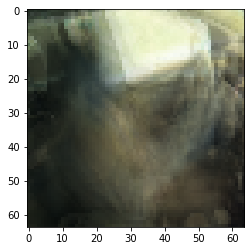

[32 41 33 ... 14 14 15]


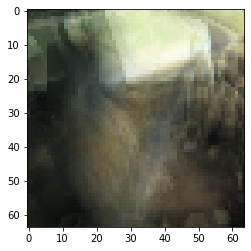

[33 42 33 ... 22 24 26]


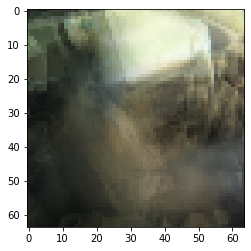

In [47]:
grouped = non_mean.groupby('Class')
sum_0 = np.zeros(12288,dtype=int)
for i in grouped.get_group('0')['Vector']:
    sum_0 += i
mean_0 = (sum_0/grouped.get_group('0').shape[0]).astype(int)
print(mean_0)
mean_image = mean_0.reshape(64,64,3)
plt.imshow(mean_image)
plt.show()

sum_1 = np.zeros(12288,dtype=int)
for i in grouped.get_group('1')['Vector']:
    sum_1 += i
mean_1 = (sum_1/grouped.get_group('1').shape[0]).astype(int)
print(mean_1)
mean_image = mean_1.reshape(64,64,3)
plt.imshow(mean_image)
plt.show()

sum_5 = np.zeros(12288,dtype=int)
for i in grouped.get_group('5')['Vector']:
    sum_5 += i
mean_5 = (sum_5/grouped.get_group('5').shape[0]).astype(int)
print(mean_5)
mean_image = mean_5.reshape(64,64,3)
plt.imshow(mean_image)
plt.show()



In [4]:
temp = []
for i in data['Vector']:
    temp.append(i)
X = np.array(temp)
print(X)

[[ -8.74415804  -7.11309311  -6.20620763 ... -12.65996254  -9.04285587
   -9.23595255]
 [-25.74415804 -30.11309311 -23.20620763 ... -11.65996254  -8.04285587
   -8.23595255]
 [ -7.74415804  -7.11309311  -4.20620763 ...  -9.65996254  -8.04285587
   -8.23595255]
 ...
 [ 11.25584196  10.88690689   6.79379237 ...   6.34003746   9.95714413
    9.76404745]
 [ -7.74415804  -3.11309311  -0.20620763 ...  -6.65996254  -5.04285587
   -5.23595255]
 [ 31.25584196  29.88690689  31.79379237 ...  30.34003746  24.95714413
   22.76404745]]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, data['Class'], test_size=0.2)
clf = GaussianNB()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

0.5662522994592787


In [6]:
predicted = clf.predict(X_test)
expected = y_test



In [7]:
matches = (predicted == expected)
print(matches.sum())
print(len(matches))
matches.sum() / float(len(matches))

2479
4485


0.5527313266443701

In [8]:
from sklearn import metrics
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.41      0.59      0.48       467
           1       0.50      0.54      0.52       479
           2       0.50      0.60      0.54       466
           3       0.68      0.48      0.56       485
           4       0.59      0.39      0.47       492
           5       0.54      0.79      0.64       456
           6       0.61      0.48      0.54       423
           7       0.75      0.67      0.71       396
           8       0.72      0.52      0.61       386
           9       0.49      0.49      0.49       435

    accuracy                           0.55      4485
   macro avg       0.58      0.55      0.56      4485
weighted avg       0.57      0.55      0.55      4485



In [ ]:
pca = PCA(n_components=10)
proj = pca.fit_transform(X)
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target, cmap="Paired")
plt.colorbar()

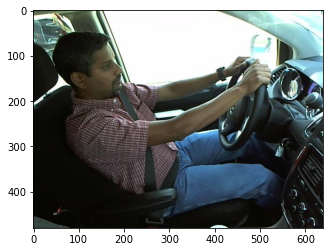

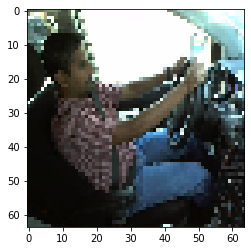

[[[ 75  98  83]
  [ 77 100  86]
  [ 77 104  89]
  ...
  [255 255 239]
  [253 255 239]
  [254 253 233]]

 [[113 138 130]
  [210 234 226]
  [241 253 249]
  ...
  [254 254 240]
  [255 253 239]
  [254 251 253]]

 [[250 254 249]
  [249 255 245]
  [205 217 194]
  ...
  [255 253 220]
  [255 255 226]
  [255 255 232]]

 ...

 [[ 63  68  53]
  [ 70  75  64]
  [ 27  33  28]
  ...
  [ 53  50  28]
  [ 37  35  33]
  [  8  11  15]]

 [[ 66  71  55]
  [ 64  70  54]
  [ 62  67  52]
  ...
  [ 17  16  23]
  [ 30  25  24]
  [ 18  19  23]]

 [[ 61  65  51]
  [ 64  68  54]
  [ 64  69  54]
  ...
  [ 32  32  44]
  [ 24  18  18]
  [ 14  15  19]]]
[75 98 83 ... 14 15 19]


In [4]:
img = cv2.imread('Images/imgs/train/c0/img_34.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

height = 64
width = 64
img = cv2.resize(img, (height, width), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

print(img)
print(img.flatten())

In [6]:
np.set_printoptions(threshold=np.inf)

def preprocessing1(image_path):
    global test_dataframe
    try:
        img = cv2.imread(image_path)
    except IOError:
        print("image could not be found")

    height, width, columns = img.shape

    height = 64
    width = 64
    img = cv2.resize(img, (height, width), interpolation=cv2.INTER_LINEAR)

    img = img.flatten()
    name = image_path.split("/")[-1]
    test_dataframe = test_dataframe.append({'Image_name': name, 
                                            "Vector": img}
                                            ,ignore_index=True)
    print("done printing for ", name)


train_path = 'Images/imgs/test/' 
test_dataframe = pd.DataFrame(columns=['Image_name', 'Vector'])

with os.scandir(train_path) as entries:
      for entry in entries:
          path = train_path + '/' + entry.name
          preprocessing1(path)

done printing for  img_13858.jpg
done printing for  img_13860.jpg
done printing for  img_13862.jpg
done printing for  img_13864.jpg
done printing for  img_13865.jpg
done printing for  img_13866.jpg
done printing for  img_13867.jpg
done printing for  img_13869.jpg
done printing for  img_1387.jpg
done printing for  img_13870.jpg
done printing for  img_13871.jpg
done printing for  img_13872.jpg
done printing for  img_13874.jpg
done printing for  img_13875.jpg
done printing for  img_13877.jpg
done printing for  img_13878.jpg
done printing for  img_13879.jpg
done printing for  img_13880.jpg
done printing for  img_13881.jpg
done printing for  img_13882.jpg
done printing for  img_13883.jpg
done printing for  img_13884.jpg
done printing for  img_13885.jpg
done printing for  img_13886.jpg
done printing for  img_13887.jpg
done printing for  img_13888.jpg
done printing for  img_1389.jpg
done printing for  img_13890.jpg
done printing for  img_13891.jpg
done printing for  img_13892.jpg
done printin

KeyboardInterrupt: 

In [ ]:
test_dataframe.to_pickle("test_pickle.pkl")